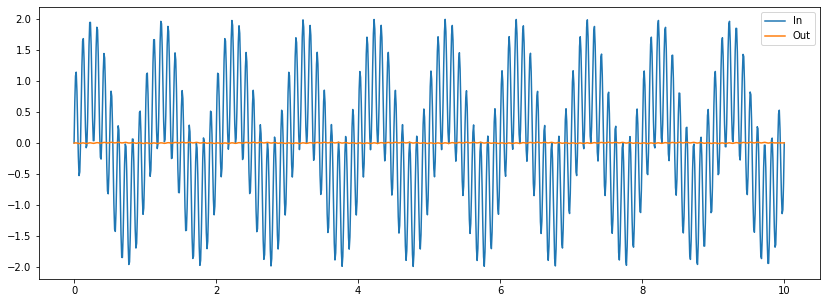

In [27]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, GRU, Dense, Masking, Reshape, Flatten, RepeatVector, TimeDistributed, Bidirectional, Activation, GaussianNoise, Lambda, LSTM
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from Models.BioSigBandVAE_MultiM import *
from Utilities.Utilities import *


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

# FIR 필터 계수 생성
M = 31  # 필터 길이
alpha = 0.0001 

n = np.arange(M)
h = np.sinc((n-M/2)/4) * np.hamming(M) * 2  # 필터 계수
#h *= np.exp(-0.1 * np.arange(M))  # 고주파 감쇠
h *= np.exp(-alpha*(n/fc)**2)  # 고주파 감쇠


# 입력 신호 생성
t = np.linspace(0, 10, 1000)
x = np.sin(2*np.pi*t)  + np.sin(2*np.pi*10*t)
Data= x[None]

# 필터링 수행
y = np.convolve(x, h, mode='same')

# 결과 출력
plt.figure(figsize=(14,5))
plt.plot(t, x, label='In')
plt.plot(t, y, label='Out')
plt.legend()
plt.show()

In [171]:
DATA = np.load('./Data/AsanTRSet.npy')
SigDim = DATA.shape[1]



In [128]:
N = 301
LF = 0.01
nVec = np.arange(N)
Window = tf.signal.hamming_window(N) # , dtype=tf.float64

# A low-pass filter
X = 2 * LF * (nVec - (N - 1) / 2)
X = tf.where(X == 0, 1e-7, X)
#X = tf.maximum(X,  1e-7)
LPF = tf.sin(np.pi*X)/(np.pi*X)
LPF *= Window 
LPF /= tf.reduce_sum(LPF, axis=-1, keepdims=True)

LPF *=  np.exp(-0.01 * np.arange(N)) 

Filter = LPF[None,None]


# Create a high-pass filter from the low-pass filter through spectral inversion.
HPF = -LPF

## To make HPF[(N - 1) // 2] += 1
Mask = np.zeros(HPF.shape[0])
Mask[(N - 1) // 2] += 1
Mask = tf.constant(Mask, dtype=tf.float32)
HPF = HPF + Mask

HPF *=  np.exp(-0.01 * np.arange(N)) 


Filter = HPF[None,None]


In [129]:
## Perform signal filtering level 2
Frame_L =  tf.signal.frame(Data,301, 1)
Frame_L = tf.cast(Frame_L, tf.float32)
Sig_LH = tf.reduce_sum(Frame_L*Filter[:,:,::-1], axis=-1, keepdims=True)



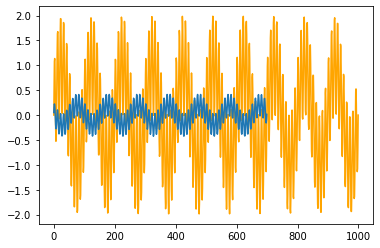

In [130]:
plt.plot(x, label='In', c='orange')
plt.plot(Sig_LH[0, :, 0])

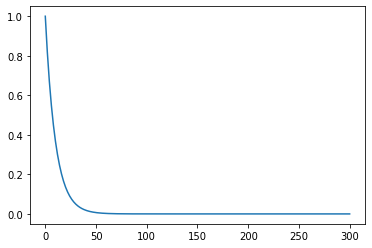

In [131]:
plt.plot(np.exp(-0.1 * np.arange(N)))

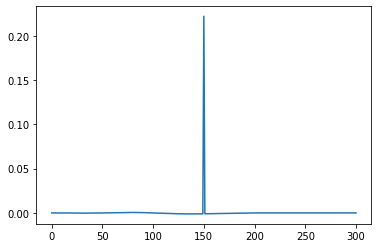

In [132]:
plt.plot(Filter[0,0])


In [426]:
SigDim = 1000 
LatDim= 2 
FiltLenList = [301, 301, 301, 301, 301, 301]

EncReInp = Input(shape=(SigDim,), name='Inp_EncRe')
FCs = Input(shape=(6,), name='Inp_FCs')

H_F, L_F, HH_F, HL_F, LH_F, LL_F = tf.split(FCs, 6, axis=1)


### Filtering level 1 -------------------------------------------------------------------
## Filter generation
To_H = GenHighFilter(H_F,  N=FiltLenList[0])
To_L = GenLowFilter(L_F, N=FiltLenList[1])


In [448]:
H_F = np.linspace(0, 0.01, 100)[:, None]
L_F = np.linspace(0, 0.49, 100)[:, None]

To_H_deca = GenHighFilter(H_F,  N=FiltLenList[0], Decay=0.1)
To_H_normal = GenHighFilter(H_F,  N=FiltLenList[0], Decay=0)

## Perform signal filtering level 1
InpFrame =  tf.signal.frame(DATA[:100], To_H_deca.shape[-1], 1)
Sig_H_deca = tf.reduce_sum(InpFrame*To_H_deca[:,:,::-1], axis=-1, keepdims=True)
Sig_H_normal = tf.reduce_sum(InpFrame*To_H_normal[:,:,::-1], axis=-1, keepdims=True)


To_L_deca = GenLowFilter(L_F,  N=FiltLenList[0], Decay=0.05)
To_L_normal = GenLowFilter(L_F,  N=FiltLenList[0], Decay=0)

## Perform signal filtering level 1
InpFrame =  tf.signal.frame(DATA[:100], To_H_deca.shape[-1], 1)
Sig_L_deca = tf.reduce_sum(InpFrame*To_L_deca[:,:,::-1], axis=-1, keepdims=True)
Sig_L_normal = tf.reduce_sum(InpFrame*To_L_normal[:,:,::-1], axis=-1, keepdims=True)

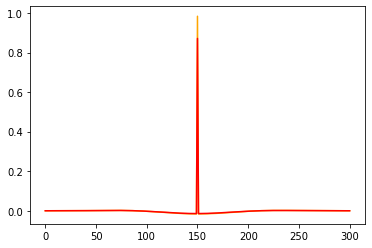

In [449]:
#plt.plot(To_H_normal[80,0])
plt.plot(To_H_normal[80,0], c='orange')
plt.plot(To_H_deca[80,0], c='red')



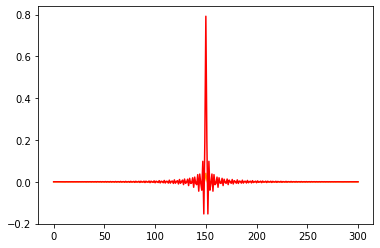

In [450]:
plt.plot(To_L_deca[80,0], c='orange')
plt.plot(To_L_normal[80,0], c='red')

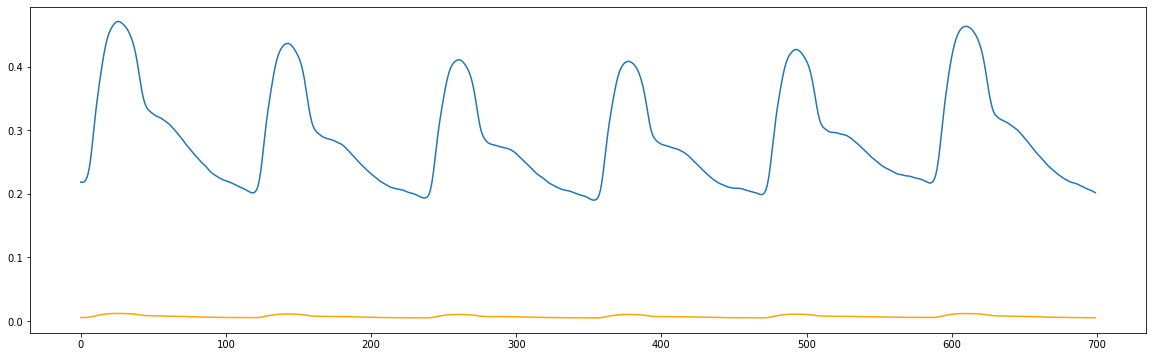

In [451]:
plt.figure(figsize=(20,6))
plt.plot(Sig_L_normal[-1, :, 0])
plt.plot(Sig_L_deca[-1, :, 0], c='orange')

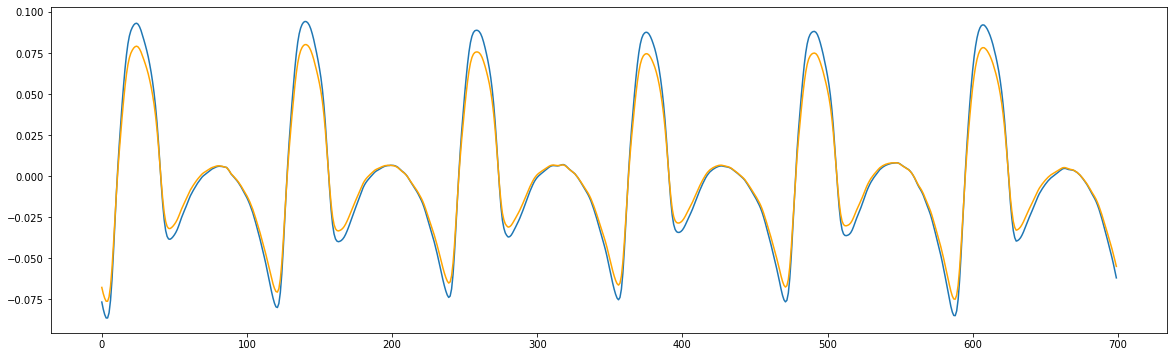

In [452]:
plt.figure(figsize=(20,6))
plt.plot(Sig_H_normal[-1, :, 0])
plt.plot(Sig_H_deca[-1, :, 0], c='orange')


In [443]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, GRU, Dense, Masking, Reshape, Flatten, RepeatVector, TimeDistributed, Bidirectional, Activation, GaussianNoise, Lambda
from tensorflow.keras import Model



def MaskingGen ( InpRegul, MaskingRate = 0.025, MaskStd = 0.1):
    ## Masking vector generation 1 vs 0
    NBatch = tf.shape(InpRegul)[0]
    
    MaskIDX = tf.random.shuffle(tf.range(NBatch * InpRegul.shape[1] ))
    CutIDX = tf.cast(  tf.cast(tf.shape(MaskIDX)[0], dtype=tf.float32) * (1-MaskingRate), dtype=tf.int32 )
    MaskIDX = tf.cast(MaskIDX < CutIDX, dtype=tf.float32)
    MaskVec = tf.reshape(MaskIDX, (NBatch, -1))[:,:,None]
    
    ## Noise vector generation 1 vs 0; Enocder 에서는 masking {0 vs 1}을 통해 BP가 되지 않도록 제어; Filtering (feature extracting) part에서는 encoder에서 masking 된 부분에 noise를 추가해줌
    RevMaskIDX = MaskIDX == 0
    RevMaskIDX = tf.cast(RevMaskIDX, dtype=tf.float32)
    NoisVec = RevMaskIDX * tf.random.normal(tf.shape(RevMaskIDX), stddev=MaskStd)
    NoisVec = tf.reshape(NoisVec, (NBatch, -1))[:,:,None]
    return MaskVec, NoisVec


def GenLowFilter (LF, N = 401, Decay=0):
    nVec = np.arange(N)
    Window = tf.signal.hamming_window(N)

    # A low-pass filter
    X = 2 * LF * (nVec - (N - 1) / 2)
    X = tf.where(X == 0, 1e-7, X)
    LPF = tf.sin(np.pi*X)/(np.pi*X)
    LPF *= Window
    LPF /= tf.reduce_sum(LPF, axis=-1, keepdims=True)
    
    # Freq cutoff Decay effect
    if Decay != 0:
        #LPF *= np.exp(-Decay * nVec) 
        LPF *= np.exp(-LF * Decay * nVec) 
    
    return LPF[:,None] 


def GenHighFilter (HF, N = 401, Decay=0):
    nVec = np.arange(N)
    Window = tf.signal.hamming_window(N)

    # A high-pass filter
    Y = 2 * HF * (nVec - (N - 1) / 2)
    Y = tf.where(Y == 0, 1e-7, Y)
    HPF = tf.sin(np.pi*Y)/(np.pi*Y)
    HPF *= Window
    HPF /= tf.reduce_sum(HPF, axis=-1, keepdims=True)
    HPF = -HPF

    ## To make HPF[(N - 1) // 2] += 1
    Mask = np.zeros(HPF.shape[1])
    Mask[(N - 1) // 2] += 1
    Mask = tf.constant(Mask, dtype=tf.float32)
    HPF = HPF + Mask
    
    # Freq cutoff Decay effect
    if Decay != 0:
        #HPF *= np.exp(-Decay * nVec) 
        HPF *= np.exp(-HF * Decay * nVec) 
    
    return HPF[:,None] 


def ReName (layer, name):
    return Lambda(lambda x: x, name=name)(layer)





## --------------------------------------------------    Models   ------------------------------------------------------------
## --------------------------------------------------   Encoder  -------------------------------------------------------------
def Encoder(SigDim, LatDim= 2, Type = '', MaskingRate = 0.025, NoiseStd = 0.002, MaskStd = 0.1, ReparaStd = 0.1 , Reparam = False, FcLimit=0.1):

    InpL = Input(shape=(SigDim,), name='Inp_Enc')
    InpFrame = tf.signal.frame(InpL, 100, 100)

    if Reparam:
        InpRegul = GaussianNoise(stddev=NoiseStd)(InpFrame, training=Reparam)
        MaskVec, NoisVec = MaskingGen(InpRegul, MaskingRate, MaskStd)
        EncInp = Masking(mask_value=0.)(InpRegul * MaskVec )
        EncOut = InpRegul + NoisVec
    else:
        EncInp, EncOut = InpFrame, InpFrame

    Encoder = Dense(50, activation='relu')(InpFrame)
    Encoder = Bidirectional(GRU(30, return_sequences=True))(Encoder)
    Encoder = Bidirectional(GRU(30, return_sequences=False))(Encoder)
    Encoder = Dense(50, activation='relu')(Encoder)
    Encoder = Dense(30, activation='relu')(Encoder)
    Encoder = Dense(15, activation='relu')(Encoder)

    Z_Mu = Dense(LatDim, activation='linear', name='Z_Mu')(Encoder)
    Z_Log_Sigma = Dense(LatDim, activation='softplus')(Encoder)
    Z_Log_Sigma = ReName(Z_Log_Sigma,'Z_Log_Sigma'+Type)

    
    # Reparameterization Trick for sampling from Guassian distribution
    Epsilon = tf.random.normal(shape=(tf.shape(Z_Mu)[0], Z_Mu.shape[1]), mean=0., stddev=ReparaStd)

    if Reparam==False:
        Epsilon = Epsilon * 0

    Zs = Z_Mu + tf.exp(0.5 * Z_Log_Sigma) * Epsilon
    Zs = ReName(Zs,'Zs'+Type)
    
    FC_Mu =   Dense(6, activation='relu')(Encoder)
    FC_Mu =   Dense(6, activation='sigmoid')(FC_Mu)
    FC_Mu = tf.clip_by_value(FC_Mu, 1e-7, 1-1e-7)
    FC_Mu = ReName(FC_Mu,'FC_Mu')
    
    # Reparameterization Trick for sampling from Uniformly distribution; ϵ∼U(0,1) 
    Epsilon = tf.random.uniform(shape=(tf.shape(FC_Mu)[0], FC_Mu.shape[1]))
    Epsilon = tf.clip_by_value(Epsilon, 1e-7, 1-1e-7)
    
    LogEps = tf.math.log(Epsilon)
    LogNegEps = tf.math.log(1 - Epsilon)
    
    LogTheta = tf.math.log(FC_Mu)
    LogNegTheta = tf.math.log(1-FC_Mu)
    
    if Reparam==True:
        FCs = tf.math.sigmoid(LogEps - LogNegEps + LogTheta - LogNegTheta) * 1. + FC_Mu * 0.
    else:
        FCs = tf.math.sigmoid(LogEps - LogNegEps + LogTheta - LogNegTheta) * 0. + FC_Mu * 1.
    
    FCs = FCs * FcLimit
    FCs = tf.clip_by_value(FCs, 1e-7, FcLimit-1e-7)
    FCs = ReName(FCs, 'FCs')
    
    return Model(InpL, [Flatten(name='SigOut')(EncOut), FCs, Zs]) 




## --------------------------------------------------   FeatExtractor  -------------------------------------------------------------
def FeatExtractor(SigDim, LatDim= 2, FiltLenList = [301, 301, 301, 301, 301, 301] ):
    
    EncReInp = Input(shape=(SigDim,), name='Inp_EncRe')
    FCs = Input(shape=(6,), name='Inp_FCs')
    
    H_F, L_F, HH_F, HL_F, LH_F, LL_F = tf.split(FCs, 6, axis=1)
    

    ### Filtering level 1 -------------------------------------------------------------------
    ## Filter generation
    To_H = GenHighFilter(H_F,  N=FiltLenList[0])
    To_L = GenLowFilter(L_F, N=FiltLenList[1])

    ## Perform signal filtering level 1
    InpFrame =  tf.signal.frame(EncReInp, To_H.shape[-1], 1)
    Sig_H = tf.reduce_sum(InpFrame*To_H[:,:,::-1], axis=-1, keepdims=True)
    Sig_H = ReName(Sig_H, 'Sig_H_Ext')

    InpFrame =  tf.signal.frame(EncReInp, To_L.shape[-1], 1)
    Sig_L = tf.reduce_sum(InpFrame*To_L[:,:,::-1], axis=-1, keepdims=True)
    Sig_L = ReName(Sig_L, 'Sig_L_Ext')



    ### Filtering level HH and HL (from Sig_H) -------------------------------------------------------------------
    ## Filter generation
    To_HH = GenHighFilter(HH_F, N=FiltLenList[2])
    To_HL = GenLowFilter(HL_F, N=FiltLenList[3])

    ## Perform signal filtering level 2
    Frame_H =  tf.signal.frame(Sig_H[:,:,0], To_HH.shape[-1], 1)
    Sig_HH = tf.reduce_sum(Frame_H*To_HH[:,:,::-1], axis=-1, keepdims=True)
    Sig_HH = Flatten(name='Sig_HH_Ext')(Sig_HH)

    Frame_H =  tf.signal.frame(Sig_H[:,:,0], To_HL.shape[-1], 1)
    Sig_HL = tf.reduce_sum(Frame_H*To_HL[:,:,::-1], axis=-1, keepdims=True)
    Sig_HL = Flatten(name='Sig_HL_Ext')(Sig_HL)


    ### Filtering level LH and LL (from Sig_L) -------------------------------------------------------------------
    ## Filter generation
    To_LH = GenHighFilter(LH_F,  N=FiltLenList[4])
    To_LL = GenLowFilter(LL_F,  N=FiltLenList[5])

    ## Perform signal filtering level 2
    Frame_L =  tf.signal.frame(Sig_L[:,:,0], To_LH.shape[-1], 1)
    Sig_LH = tf.reduce_sum(Frame_L*To_LH[:,:,::-1], axis=-1, keepdims=True)
    Sig_LH = Flatten(name='Sig_LH_Ext')(Sig_LH)

    Frame_L =  tf.signal.frame(Sig_L[:,:,0], To_LL.shape[-1], 1)
    Sig_LL = tf.reduce_sum(Frame_L*To_LL[:,:,::-1], axis=-1, keepdims=True)
    Sig_LL = Flatten(name='Sig_LL_Ext')(Sig_LL)

    
    return Model([EncReInp, FCs], [Sig_HH, Sig_HL, Sig_LH, Sig_LL])




## --------------------------------------------------   FeatGenerator  -------------------------------------------------------------
def FeatGenerator (LatDim= 2):
    
    InpZ = Input(shape=(LatDim,), name='Inp_Z')
    FCCommon = Input(shape=(2,), name='Inp_FCCommon')
    FCEach = Input(shape=(4,), name='Inp_FCEach')
    
    HH_F, HL_F, LH_F, LL_F = tf.split(FCEach, 4, axis=1)
    
   
    Dec_Sig_HH = Dense(10, activation='relu')(tf.concat([InpZ, FCCommon, HH_F], axis=-1))
    Dec_Sig_HH = Dense(20, activation='relu')(Dec_Sig_HH)
    Dec_Sig_HH = Dense(30, activation='relu')(Dec_Sig_HH)
    Dec_Sig_HH = Dense(50, activation='relu')(Dec_Sig_HH)

    Dec_Sig_HH = RepeatVector(10 )(Dec_Sig_HH)
    Dec_Sig_HH = Bidirectional(GRU(10, return_sequences=True))(Dec_Sig_HH)
    Dec_Sig_HH = Bidirectional(GRU(20, return_sequences=True))(Dec_Sig_HH)
    Dec_Sig_HH = Dense(40,'tanh')(Dec_Sig_HH)
    Sig_HH= Flatten(name='Sig_HH_Gen')(Dec_Sig_HH)
    
    # ---------------------------------------------------------------------- #
    
    Dec_Sig_HL = Dense(10, activation='relu')(tf.concat([InpZ, FCCommon, HL_F], axis=-1))
    Dec_Sig_HL = Dense(20, activation='relu')(Dec_Sig_HL)
    Dec_Sig_HL = Dense(30, activation='relu')(Dec_Sig_HL)
    Dec_Sig_HL = Dense(50, activation='relu')(Dec_Sig_HL)

    Dec_Sig_HL = RepeatVector(10 )(Dec_Sig_HL)
    Dec_Sig_HL = Bidirectional(GRU(10, return_sequences=True))(Dec_Sig_HL)
    Dec_Sig_HL = Bidirectional(GRU(20, return_sequences=True))(Dec_Sig_HL)
    Dec_Sig_HL = Dense(40,'tanh')(Dec_Sig_HL)
    Sig_HL= Flatten(name='Sig_HL_Gen')(Dec_Sig_HL)
    
    # ---------------------------------------------------------------------- #
    
    Dec_Sig_LH = Dense(10, activation='relu')(tf.concat([InpZ, FCCommon, LH_F], axis=-1))
    Dec_Sig_LH = Dense(20, activation='relu')(Dec_Sig_LH)
    Dec_Sig_LH = Dense(30, activation='relu')(Dec_Sig_LH)
    Dec_Sig_LH = Dense(50, activation='relu')(Dec_Sig_LH)

    Dec_Sig_LH = RepeatVector(10 )(Dec_Sig_LH)
    Dec_Sig_LH = Bidirectional(GRU(10, return_sequences=True))(Dec_Sig_LH)
    Dec_Sig_LH = Bidirectional(GRU(20, return_sequences=True))(Dec_Sig_LH)
    Dec_Sig_LH = Dense(40,'tanh')(Dec_Sig_LH)
    Sig_LH= Flatten(name='Sig_LH_Gen')(Dec_Sig_LH)
    
    # ---------------------------------------------------------------------- #
    
    Dec_Sig_LL = Dense(10, activation='relu')(tf.concat([InpZ, FCCommon, LL_F], axis=-1))
    Dec_Sig_LL = Dense(20, activation='relu')(Dec_Sig_LL)
    Dec_Sig_LL = Dense(30, activation='relu')(Dec_Sig_LL)
    Dec_Sig_LL = Dense(50, activation='relu')(Dec_Sig_LL)

    Dec_Sig_LL = RepeatVector(10 )(Dec_Sig_LL)
    Dec_Sig_LL = Bidirectional(GRU(10, return_sequences=True))(Dec_Sig_LL)
    Dec_Sig_LL = Bidirectional(GRU(20, return_sequences=True))(Dec_Sig_LL)
    Dec_Sig_LL = Dense(40,'tanh')(Dec_Sig_LL)
    Sig_LL= Flatten(name='Sig_LL_Gen')(Dec_Sig_LL)
    
    return  Model([FCCommon, FCEach, InpZ], [Sig_HH, Sig_HL, Sig_LH, Sig_LL])



## --------------------------------------------------   Reconstructor  -------------------------------------------------------------
def Reconstructor(SigDim , FeatDim=400 ):
    
    Sig_HH = Input(shape=(FeatDim,), name='Inp_Sig_HH')
    Sig_HL = Input(shape=(FeatDim,), name='Inp_Sig_HL')
    Sig_LH = Input(shape=(FeatDim,), name='Inp_Sig_LH')
    Sig_LL = Input(shape=(FeatDim,), name='Inp_Sig_LL')
    FCs = Input(shape=(6,), name='Inp_FCs')

    ## GRU NET -------------------------------------------------------------------
    Dec_Sig_HH = Reshape((-1, 100))(Sig_HH)
    Dec_Sig_HL = Reshape((-1, 100))(Sig_HL)
    Dec_Sig_LH = Reshape((-1, 100))(Sig_LH)
    Dec_Sig_LL = Reshape((-1, 100))(Sig_LL)

    Dec_Sig_HH = Bidirectional(GRU(5), name='Dec_Sig_HH')(Dec_Sig_HH)
    Dec_Sig_HL = Bidirectional(GRU(5), name='Dec_Sig_HL')(Dec_Sig_HL)
    Dec_Sig_LH = Bidirectional(GRU(5), name='Dec_Sig_LH')(Dec_Sig_LH)
    Dec_Sig_LL = Bidirectional(GRU(5), name='Dec_Sig_LL')(Dec_Sig_LL)

    Decoder = tf.concat([ Dec_Sig_HH, Dec_Sig_HL, Dec_Sig_LH, Dec_Sig_LL, FCs], axis=1)
    Decoder = RepeatVector((SigDim//100) )(Decoder)
    Decoder = Bidirectional(GRU(50, return_sequences=True))(Decoder)
    Decoder = Dense(100, activation='relu')(Decoder)
    DecOut = Dense(100, activation='sigmoid')(Decoder)
    DecOut = Reshape((SigDim,),name='Out')(DecOut)

    return Model([Sig_HH, Sig_HL, Sig_LH, Sig_LL, FCs], DecOut)